### Data Pipeline
Data Sources: CSV files containing wind speed and direction data from remote sensing devices.

Data Cleaning: Clean and preprocess the data using Python libraries such as Pandas. Remove duplicates, handle missing values, and ensure data consistency.

Data Storage: Store the cleaned data into a PostgreSQL database. Use SQL queries to optimize data storage and retrieval.

Machine Learning: Utilize machine learning algorithms to analyze the data, such as regression analysis or clustering. Use Python libraries such as Scikit-learn or TensorFlow.

Data Analytics: Generate insights and identify patterns in the data using Python libraries such as Matplotlib, Seaborn, or Plotly.

Data Visualization: Create interactive dashboards and visualizations using Tableau, allowing users to explore and interact with the data easily.

Presentation: Present the insights and findings to stakeholders using the Tableau dashboard.

## Data Source:

https://data.open-power-system-data.org/renewable_power_plants/2020-08-25

## Step1. Data Cleaning

In [ ]:
# read the original column headers from a CSV file 
import csv

with open('data source/renewable_power_plants_EU.csv', 'r') as f:
    reader = csv.reader(f)
    headers = next(reader) # Read the first row as column headers
    print(headers) # Print the headers to verify they have been read correctly

In [ ]:
import pandas as pd

# Define the file path and column data types
file_path = 'data source/renewable_power_plants_EU.csv'
dtypes = {'energy_source_level_3': str, 'commissioning_date': str}

# Define the chunk size for reading in the data
chunk_size = 100000

# Initialize an empty list to store the filtered data
filtered_data = []

# Iterate through the data in chunks
for chunk in pd.read_csv(file_path, dtype=dtypes, chunksize=chunk_size):
    
    # Filter the columns to keep
    keep_cols = ['electrical_capacity', 'energy_source_level_2', 'technology', 
                 'nuts_1_region', 'nuts_2_region', 'nuts_3_region', 'lon', 'lat',
                 'municipality', 'country', 'commissioning_date']
    chunk = chunk[keep_cols]

    # Filter the rows
    chunk = chunk[chunk['energy_source_level_2'] == 'Wind'] # Only keep rows where energy_source_level_2 is 'Wind'
    
    # Drop duplicates
    chunk = chunk.drop_duplicates()

    # Append the filtered data to the list
    filtered_data.append(chunk)

# Concatenate the filtered data into a single DataFrame
df = pd.concat(filtered_data, ignore_index=True)

# Save cleaned data to a new CSV file
df.to_csv('data source/wind_energy_EU_cleaned.csv', index=False)


## Step2. Data Storage

In [ ]:
import pandas as pd
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(database="mydatabase", user="myuser", password="mypassword", host="localhost", port="5432")

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('data source/wind_energy_EU_cleaned.csv')

# Insert the data into a PostgreSQL table
df.to_sql('mytable', conn, if_exists='replace')

## Step3. Machine learning

1. Time series analysis: You could analyze how the installed electrical capacity of wind energy plants has changed over time, and identify any trends or patterns.

2. Cluster analysis: You could group the wind energy plants based on their location, electrical capacity, or other variables, and identify any similarities or differences between the clusters.

3. Geographic analysis: You could create a map of the wind energy plants and visualize the distribution of the plants across different regions or countries.

4. Predictive modeling: You could use regression analysis or other machine learning techniques to predict the electrical capacity of wind energy plants based on their location, commissioning date, and other variables.

### Time series analysis

<AxesSubplot:title={'center':'Monthly Total Electrical Capacity'}, xlabel='commissioning_date'>

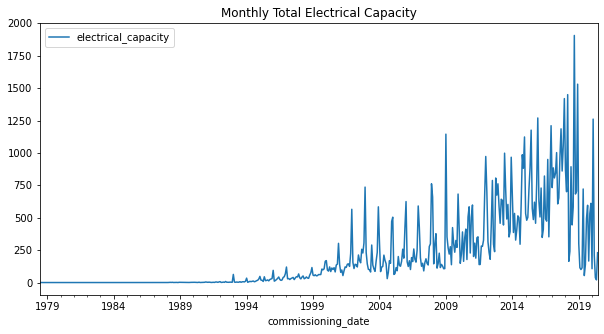

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Define the connection string
user = 'postgres'
password = 'postgresql2023'
host = 'localhost'
port = '5432'
database = 'wind_energy_database'
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# Create a connection to the database
engine = create_engine(connection_string)

# Define the SQL query to retrieve the data
query = '''
SELECT commissioning_date, electrical_capacity
FROM mytable
'''

# Load the data into a pandas dataframe
df = pd.read_sql(query, engine)

# Convert commissioning_date to a datetime object
df['commissioning_date'] = pd.to_datetime(df['commissioning_date'])

# Set the index to commissioning_date
df = df.set_index('commissioning_date')

# Resample the data to monthly frequency
monthly_df = df.resample('M').sum()

# Plot the data
monthly_df.plot(figsize=(10,5), title='Monthly Total Electrical Capacity')

### Cluster Analysis using K-Means clustering algorithm

d:\Software Program Files\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


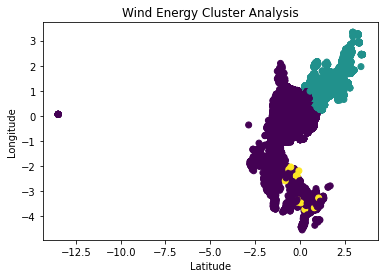

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SQL query to select relevant columns
query = """
SELECT electrical_capacity, lon, lat
FROM mytable
"""

# read data into a pandas dataframe
df = pd.read_sql(query, engine)

# drop any rows with missing values
df = df.dropna()

# normalize the data
df_norm = (df - df.mean()) / df.std()

# use K-Means clustering algorithm
kmeans = KMeans(n_clusters=3, random_state=42).fit(df_norm[['electrical_capacity', 'lat', 'lon']])

# plot the results
plt.scatter(df_norm['lat'], df_norm['lon'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Wind Energy Cluster Analysis')
plt.show()

### Geographic analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sqlalchemy import create_engine

# Define the connection string
user = 'postgres'
password = 'postgresql2023'
host = 'localhost'
port = '5432'
database = 'wind_energy_database'
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# Create a connection to the database
engine = create_engine(connection_string)

# define the SQL query to retrieve data with location information
query = '''
SELECT electrical_capacity, energy_source_level_2, technology, nuts_1_region, nuts_2_region, nuts_3_region,
       lon, lat, municipality, country, commissioning_date
FROM mytable
WHERE lon IS NOT NULL AND lat IS NOT NULL
'''

# Load the data into a pandas dataframe
df = pd.read_sql(query, engine)

# # create a Basemap object to plot the map
# m = Basemap(llcrnrlon=-10, llcrnrlat=35, urcrnrlon=35, urcrnrlat=70, resolution='i')

# # plot the map boundaries, coastlines, and countries
# m.drawmapboundary()
# m.drawcoastlines(linewidth=0.5)
# m.drawcountries(linewidth=0.5)

# # plot the data as points on the map
# x, y = m(df['lon'].values, df['lat'].values)
# m.plot(x, y, 'bo', markersize=4)

# # add a title to the plot
# plt.title('Wind Energy Facilities in Europe')

# # show the plot
# plt.show()

# Create a map using Basemap
fig, ax = plt.subplots(figsize=(16,12))
m = Basemap(projection='merc', lat_0=50, lon_0=10,
            resolution='h', area_thresh=10000.0,
            llcrnrlon=-11.5, llcrnrlat=34.5,
            urcrnrlon=34.0, urcrnrlat=71.5)
m.drawcoastlines()
m.drawcountries()
# Fill the continents with a light gray color
m.fillcontinents(color='#FAEDCD', lake_color='#46bcec')

m.drawmapboundary(fill_color='#EEEEEE')

# Plot the locations of wind turbines on the map
x, y = m(df['lon'].values, df['lat'].values)
m.scatter(x, y, marker='o', alpha=0.5)

# Set the title of the plot
plt.title('Locations of Wind Turbines with Electrical Capacity >= 5 MW')

# Display the plot
plt.show()

### Predictive modeling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the connection string
user = 'postgres'
password = 'postgresql2023'
host = 'localhost'
port = '5432'
database = 'wind_energy_database'
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# Create a connection to the database
engine = create_engine(connection_string)

# read the data from the PostgreSQL table into a Pandas DataFrame
df = pd.read_sql_table('mytable', engine)

# drop any rows with missing values
df = df.dropna()

# select the features and target variable
features = ['electrical_capacity', 'lon', 'lat']
target = 'commissioning_date'

# Parse the dates and convert to number of days since the earliest date
ref_date = min(df['commissioning_date'])
df['commissioning_date'] = (pd.to_datetime(df['commissioning_date']) - pd.to_datetime(ref_date)).dt.days

X = df[features]
y = df[target]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a linear regression model on the training set
lr = LinearRegression()
lr.fit(X_train, y_train)

# make predictions on the testing set
y_pred = lr.predict(X_test)

# evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.2f}")

Mean squared error: 7452186.23


Ref:

https://github.com/Shaza-Safi/Ontario_Sunshine_List

https://github.com/microsoft/ML-For-Beginners

https://github.com/microsoft/Data-Science-For-Beginners

https://github.com/microsoft/AI-For-Beginners